<a href="https://colab.research.google.com/github/haeeeeuni/Deeplearning_assignments/blob/main/Deeplearning_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 시작전

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
import zipfile
import os

# 드라이브 내 압축 파일 경로
zip_path = '/content/drive/MyDrive/frames-20240619T151930Z-007.zip'
# 압축 파일의 경로를 지정하세요(1~7 파일)
extract_path = '/content/drive/MyDrive/frames'  # 압축을 풀 폴더의 경로

# 압축 해제할 폴더가 없으면 생성
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Files extracted to {extract_path}')

'''


Files extracted to /content/drive/MyDrive/frames


# 실습 과제3: Optical Flow, LSTM, Depth Estimation

각 실습 과제의 목표 및 목적
- 실습 과제의 진행 과정 구체적인 숫자 포함
- 실습 과제 결과
- 생각해볼 점, 논의할 점, 이외에 본인이 기록하고 싶은 모든 것 가능
- 전체적으로 필요시 학습 속도 (Learning Curve)와 모델의 Training 및 Inference 시간, 파라미터의 수를 비교하세요.

### **실습 과제 1.** 본인의 이미지 2장을 이용하여 optical flow 그리세요.

- https://github.com/jooyongsim/deeplearning_SMWU_2024/blob/main/notebooks/Lab8_Optical%20Flow.ipynb

- optical flow를 그리려면 depth map이 있어야 하는 것 같음,,, 3번부터 해라

**OpenEXR 설치**

In [6]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
pip install OpenEXR

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00


### resize image

In [13]:
# prompt: resize image

from PIL import Image

image_path = '/content/drive/MyDrive/resized_images_exr/IMG_4060.JPG'
output_path = '/content/drive/MyDrive/resized_images_exr/IMG_4060_resized.JPG'
# Open the image
image = Image.open(image_path)

# Define the desired size
target_size = (224, 224)

# Resize the image
resized_image = image.resize(target_size)

# Save the resized image
resized_image.save(output_path)


In [14]:
image_path = '/content/drive/MyDrive/resized_images_exr/IMG_4080.JPG'
output_path = '/content/drive/MyDrive/resized_images_exr/IMG_4080_resized.JPG'
# Open the image
image = Image.open(image_path)

# Define the desired size
target_size = (224, 224)

# Resize the image
resized_image = image.resize(target_size)

# Save the resized image
resized_image.save(output_path)

### **Using MiDAS model to make Depth Map**

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:05<00:00, 263MB/s]


Saved EXR file: /content/drive/MyDrive/resized_images_exr/IMG_4060.depth.exr.tiff
Saved EXR file: /content/drive/MyDrive/resized_images_exr/IMG_4080.depth.exr.tiff


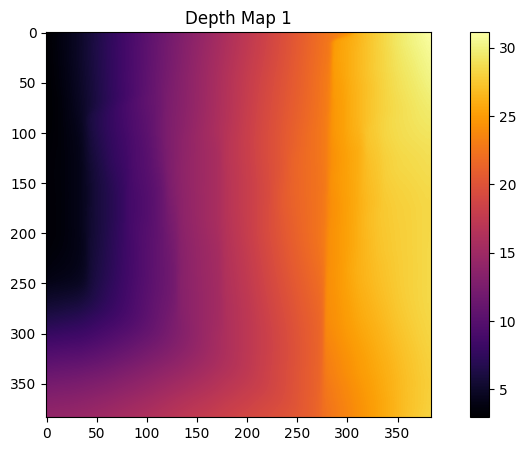

In [15]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import cv2
import OpenEXR
import Imath
import os

# MiDAS 모델 불러오기
model_type = "DPT_Large"  # 또는 "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# 사용자 정의 transform 함수 -> type
def custom_transform(image):
    # 이미지 크기 조정
    image = cv2.resize(image, (384, 384))  # 원하는 크기로 조정
    image = image / 255.0  # 정규화
    return torch.tensor(image).permute(2, 0, 1).float()  # HWC에서 CHW로 변환

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)  # 이미지를 NumPy 배열로 변환
    img = custom_transform(img)  # 사용자 정의 변환 적용
    img = img.to(device)  # GPU로 이동
    return img

# Depth Estimation 함수
def estimate_depth(image_path):
    img = preprocess_image(image_path)
    with torch.no_grad():
        prediction = midas(img.unsqueeze(0))
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[1:],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    output = prediction.cpu().numpy()
    return output

# Depth Map을 EXR 파일로 저장하는 함수
def save_depth_as_exr(depth_map, exr_file):
    height, width = depth_map.shape
    header = OpenEXR.Header(width, height)
    float_channel = Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT))
    header['channels'] = {'R': float_channel}

    exr = OpenEXR.OutputFile(exr_file, header)
    exr.writePixels({'R': depth_map.astype(np.float32).tobytes()})
    exr.close()
    print(f"Saved EXR file: {exr_file}")

# 예제 이미지에 대해 Depth Estimation 수행 및 저장
image_paths = ["/content/drive/MyDrive/resized_images_exr/IMG_4060.JPG",
               "/content/drive/MyDrive/resized_images_exr/IMG_4080.JPG"]
output_exr_files = ["/content/drive/MyDrive/resized_images_exr/IMG_4060.depth.exr.tiff",
                    "/content/drive/MyDrive/resized_images_exr/IMG_4080.depth.exr.tiff"]

for image_path, exr_file in zip(image_paths, output_exr_files):
    depth_map = estimate_depth(image_path)
    save_depth_as_exr(depth_map, exr_file)

# Depth Map 시각화 (선택사항)
import matplotlib.pyplot as plt

depth_maps = [estimate_depth(image_path) for image_path in image_paths]

for i, depth_map in enumerate(depth_maps):
    plt.figure(figsize=(10, 5))
    plt.title(f'Depth Map {i+1}')
    plt.imshow(depth_map, cmap='inferno')
    plt.colorbar()
    plt.show()


### predict optical flow -> with GPT

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_optical_flow(image1_path, image2_path):
    # Load images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute Optical Flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )

    # Calculate the magnitude and angle of the flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Create an HSV image
    hsv = np.zeros_like(img1)
    hsv[..., 1] = 255

    # Set hue according to the optical flow direction
    hsv[..., 0] = angle * 180 / np.pi / 2

    # Set value according to the optical flow magnitude
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to RGB (BGR in OpenCV)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img1, img2, rgb_flow

def visualize_optical_flow(image1_path, image2_path):
    img1, img2, flow = compute_optical_flow(image1_path, image2_path)

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Optical Flow')
    plt.imshow(flow)
    plt.axis('off')

    plt.show()

# Example usage
image1_path = '/content/drive/MyDrive/resized_images_exr/IMG_4060.JPG'
image2_path = '/content/drive/MyDrive/resized_images_exr/IMG_4080.JPG'
visualize_optical_flow(image1_path, image2_path)


### predict optical flow

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if img.dtype == torch.uint8:
                print('flow')
                img = F.to_pil_image((img).to("cpu"))
            else: #torch.float32
                print('RGB')
                img = F.to_pil_image(unorm(img).to("cpu"))

            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

**Reading Videos Using Torchvision**

In [18]:
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchvision

image_folder = '/content/drive/MyDrive/resized_images_exr'

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None,resize_shape=(224, 224)):
        self.root_dir = root_dir
        self.transform = transform
        self.resize_shape = resize_shape # Store the resize shape
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.JPG')]


    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        # Use OpenEXR to open .exr files as PIL might not support it directly
        import OpenEXR
        import Imath
        exr_file = OpenEXR.InputFile(depth_path)
        dw = exr_file.header()['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        redstr = exr_file.channel('R', pt)
        depth_image = np.frombuffer(redstr, dtype=np.float32)
        depth_image.shape = (size[1], size[0])  # Numpy arrays are (row, col)

        depth_image = T.ToTensor()(depth_image)  # Convert to tensor after loading from EXR
        rgb_image = torchvision.io.read_image(rgb_path)


        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image, depth_image

transform = T.Compose(
    [
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
    ]
)


dataset = DepthDataset(image_folder, transform)
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        if tensor.dim == 4:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        else:
            tensor.mul_(self.std).add_(self.mean)
        return tensor
unorm = UnNormalize(mean=(0.5), std=(0.5))

rgb1, depth = dataset[0]
rgb_un1 = unorm(rgb1).permute((1,2,0))

rgb2, depth = dataset[1]
rgb_un2 = unorm(rgb2).permute((1,2,0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


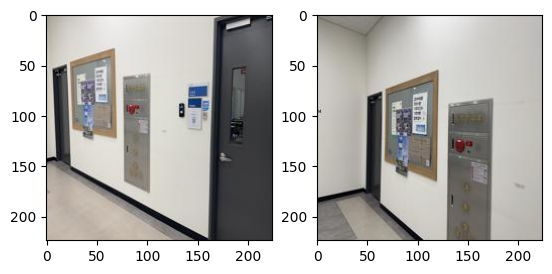

In [19]:
plt.subplot(1,2,1); plt.imshow(rgb_un1)
plt.subplot(1,2,2); plt.imshow(rgb_un2)

In [20]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for cnt, (imgs, rgbs) in enumerate(dataloader):
    print(cnt, imgs.shape, rgbs.shape)
    if cnt >= 2:
        break


img1_batch = imgs[[0]]
# Select the second and third images in the batch (index 1 and 2)
img2_batch = imgs[[1]]

plot(img1_batch)
plot(img2_batch)

0 torch.Size([2, 3, 224, 224]) torch.Size([2, 1, 384, 384])
RGB
RGB


In [21]:
# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = img1_batch.to(device)
img2_batch = img2_batch.to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([1, 3, 224, 224]), dtype = torch.float32


In [22]:
from torchvision.models.optical_flow import raft_large

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


type = <class 'list'>
length = 12 = number of iterations of the model


In [24]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([1, 2, 224, 224]) = (N, 2, H, W)
min = 5.978395462036133, max = 153.32513427734375


### **Visualizing predicted flows**

RGB
flow


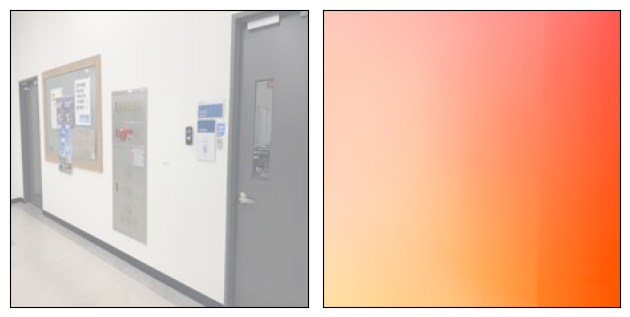

In [26]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [27]:
flow_imgs.dtype, img1_batch[0].dtype, flow_imgs.shape, img1_batch[0].shape

(torch.uint8,
 torch.float32,
 torch.Size([1, 3, 224, 224]),
 torch.Size([3, 224, 224]))

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image

def draw_flow(img, flow, step=16):
    """Draws optical flow arrows on the image."""
    print(img.shape, flow.shape)
    # flow = flow.permute((1,2,0))
    flow = flow.transpose((1,2,0))
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    # print(x, y)
    fx, fy = flow[y, x].T

    # Create a mask that will be used for drawing
    print(x.shape, fx.shape)
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    # print(img.shape)
    vis = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # vis = np.array(img)

    # Draw the lines on the image
    cv2.polylines(vis, lines, isClosed=False, color=(0, 255, 0))

    # Draw the endpoints of the flow vectors
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# Assuming predicted_flows is a batch of flow vectors and img1_batch is a batch of images
flow_imgs = flow_to_image(predicted_flows)  # Convert flow vectors to images

predicted_flows_np = predicted_flows.cpu().detach().numpy()
# Move img1_batch to CPU
img1_batch_np = [img.cpu().numpy() for img in img1_batch] # Move images to CPU

# Draw optical flow on images
flow_visualizations = [draw_flow(img1.transpose(1, 2, 0), flow_img) for img1, flow_img in zip(img1_batch_np, predicted_flows_np)]

# Setup for plotting
fig, axs = plt.subplots(len(flow_visualizations), 2, figsize=(10, len(flow_visualizations) * 5))

for i, (img, flow_viz) in enumerate(zip(img1_batch_np, flow_visualizations)):
    axs[i].imshow(img.transpose(1,2,0), cmap='gray') # Transpose here since it's already a numpy array
    axs[i].axis('off')
    axs[i].imshow(flow_viz)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

(224, 224, 3) (2, 224, 224)
(196,) (196,)


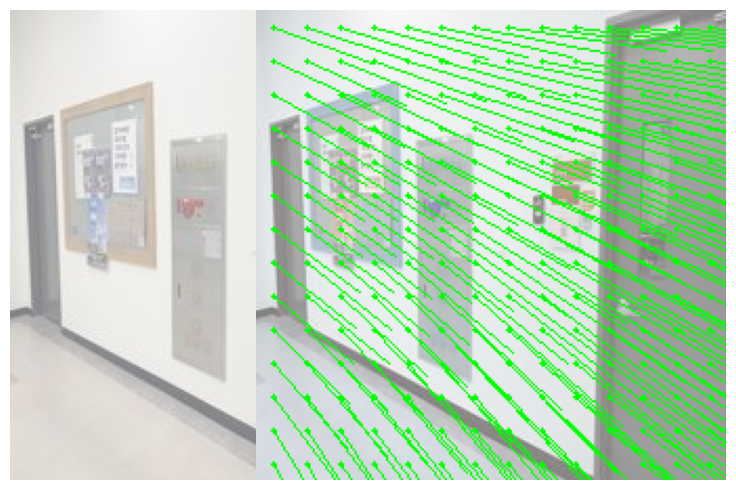

In [34]:
# Setup for plotting
fig, ax = plt.subplots(figsize=(10, 5)) # Create a single axes object

# Since there's only one image and flow visualization, no need to loop
img = img1_batch[0].cpu() # Move the tensor to CPU
flow_viz = flow_visualizations[0]

ax.imshow(img.permute((1,2,0)).numpy(), cmap='gray') # Convert to NumPy after moving to CPU
ax.axis('off')

# Create a second subplot for the flow visualization
ax_flow = fig.add_subplot(122)  # 1 row, 2 columns, second position
ax_flow.imshow(flow_viz)
ax_flow.axis('off')

plt.tight_layout()
plt.show()

### **실습 과제 2.** 본인의 pose sequence 데이터를 이용하여 순차적인 10개의 pose를 이용해 다음 3개의 pose를 예측하는 LSTM 모델을 학습시키고 결과를 논의하세요.


- Lec 17 강의자료 참고

- https://github.com/jooyongsim/deeplearning_SMWU_2024/blob/main/notebooks/Lab6_LSTM_for_Time_Series.ipynb

In [ ]:
#set training, validation, testing sequences


### **실습 과제 3.** Lab7에서 사용한 Depth Data를 이용하여 MiDAS 모델의 Depth Estimation을 수행하세요.
- MiDAS로 추정된 Disparity Map을 Ground Truth Depth Map과 비교하여 Metric
Depth Map으로 변환하세요. (frame 135, frame 520, frame 990)
- 추정된 Metric Depth Map과 Ground Truth Depth Map에 대한 pixel에 대한 scatter plot을 그리세요. 2장 이상의 이미지에 대해 비교하세요. (x축 GT depth, y축 predicted depth)

**Hint**: 이미지 마다 다른 scale과 bias값을 이용

- Lec 18 강의자료 참고

- https://github.com/jooyongsim/deeplearning_SMWU_2024/blob/main/notebooks/Lab7_Depth_Estimation.ipynb

In [36]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#set file path
path = '/content/drive/MyDrive/resized_images'

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        depth_image = Image.open(depth_path)
        rgb_image = Image.open(rgb_path)

        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image, depth_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = DepthDataset(path, transform)

**Visualize Dataset**

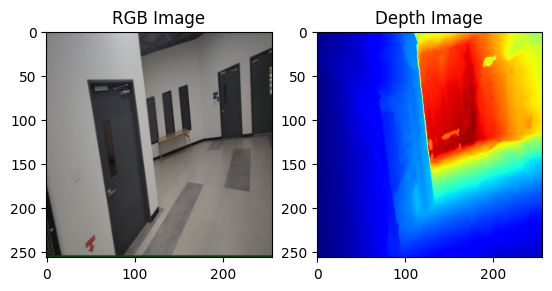

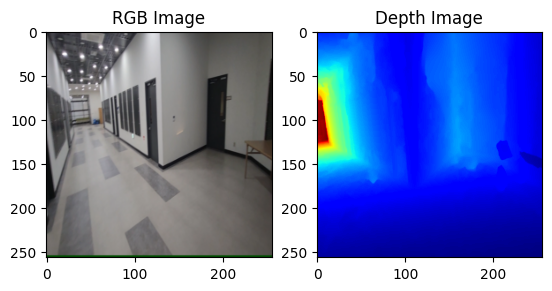

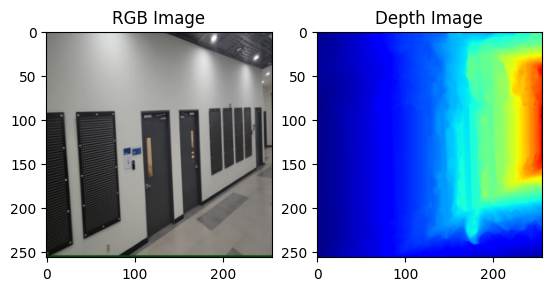

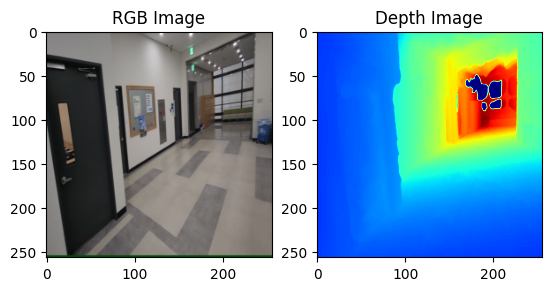

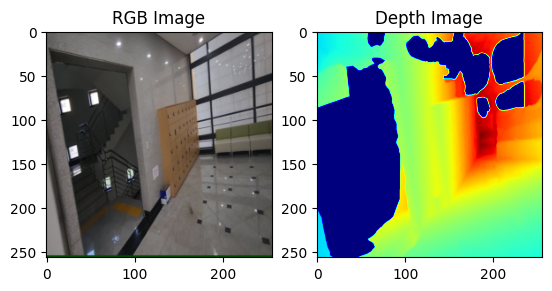

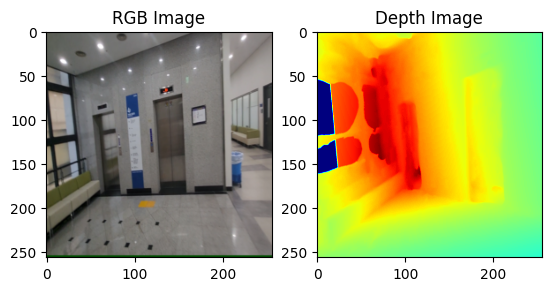

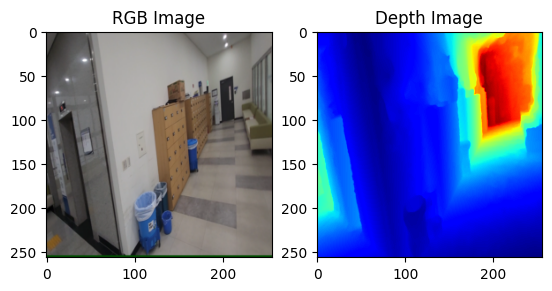

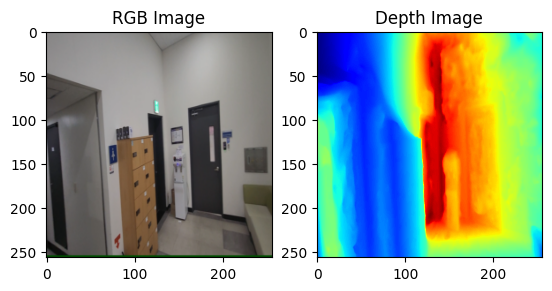

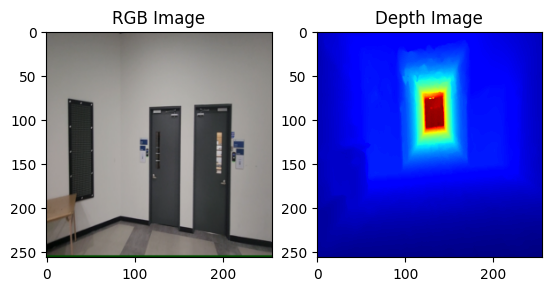

In [37]:
# prompt: Visualize the floating point depth images and RGB images

import matplotlib.pyplot as plt

num_images = 10
for i in range(50,50+num_images*50,50):
    rgb_image, depth_image = dataset[i]

    fig, axs = plt.subplots(1, 2)
    # Create a colormap for the depth image
    cmap = plt.cm.jet

    axs[0].imshow(rgb_image.permute(1, 2, 0))
    axs[0].set_title('RGB Image')
    axs[1].imshow(depth_image.permute(1, 2, 0), cmap=cmap)
    axs[1].set_title('Depth Image')
    # plt.axis('off')
    plt.show()

**Normalize with Mean & STD**

In [38]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=128, shuffle=False)
mean = 0.0
std = 0.0
total_images = 0
for cnt, (rgb, depth_image) in enumerate(loader):
    #depth_image = depth_image[1]  # get the depth image
    print(cnt, '/', len(loader), 'mean', depth_image.mean(), 'std', depth_image.std())
    if cnt == len(loader)-1:
        break
    mean += depth_image.mean()
    std += depth_image.std()
    total_images += 1

mean /= total_images
std /= total_images
mean.item(), std.item()

0 / 9 mean tensor(5.4384) std tensor(3.3358)
1 / 9 mean tensor(5.8905) std tensor(3.4054)
2 / 9 mean tensor(4.4213) std tensor(2.7097)
3 / 9 mean tensor(4.9133) std tensor(2.7678)
4 / 9 mean tensor(6.1492) std tensor(4.3147)
5 / 9 mean tensor(5.4595) std tensor(3.2755)
6 / 9 mean tensor(4.6636) std tensor(2.5328)
7 / 9 mean tensor(5.3605) std tensor(3.0863)
8 / 9 mean tensor(4.0776) std tensor(0.5290)


(5.287039279937744, 3.178504705429077)

**Normalized Dataset**

In [39]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class DepthDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        # Transform for depth images
        self.depth_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[5.288], std=[3.179])  # Normalization for depth images
        ])
        # Commonly used normalization values for RGB images
        self.rgb_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for RGB images
        ])

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        depth_image = Image.open(depth_path)
        rgb_image = Image.open(rgb_path)

        # Apply specific transformations
        depth_image = self.depth_transform(depth_image)
        rgb_image = self.rgb_transform(rgb_image)

        return rgb_image, depth_image

# Usage example
path = '/content/drive/MyDrive/resized_images'
dataset = DepthDataset(path)


**Define Simple CNN Model & Train**

In [40]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=2, padding=2)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)  # To match the label size
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.upsample(x)  # Upsample to match the original image size
        x = self.conv3(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training call
# Check if CUDA is available and if not, use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

model.to(device)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs= 20
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)  # Move inputs to device (GPU or CPU)
        labels = labels.to(device)  # Move labels to device

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}, LR: {lr}')
    if epoch % 10 == 0:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*0.5

Looking in indexes: https://download.pytorch.org/whl/cu118
CUDA is available. Training on GPU.


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/20], Step [33/33], Loss: 0.7171, LR: 0.001
Epoch [2/20], Step [33/33], Loss: 0.8145, LR: 0.0005
Epoch [3/20], Step [33/33], Loss: 0.9399, LR: 0.0005
Epoch [4/20], Step [33/33], Loss: 1.2732, LR: 0.0005
Epoch [5/20], Step [33/33], Loss: 0.4551, LR: 0.0005
Epoch [6/20], Step [33/33], Loss: 0.8429, LR: 0.0005
Epoch [7/20], Step [33/33], Loss: 0.6802, LR: 0.0005
Epoch [8/20], Step [33/33], Loss: 0.6141, LR: 0.0005
Epoch [9/20], Step [33/33], Loss: 0.6925, LR: 0.0005
Epoch [10/20], Step [33/33], Loss: 0.5591, LR: 0.0005
Epoch [11/20], Step [33/33], Loss: 0.8173, LR: 0.0005
Epoch [12/20], Step [33/33], Loss: 0.5718, LR: 0.00025
Epoch [13/20], Step [33/33], Loss: 0.4581, LR: 0.00025
Epoch [14/20], Step [33/33], Loss: 0.4818, LR: 0.00025
Epoch [15/20], Step [33/33], Loss: 0.6749, LR: 0.00025
Epoch [16/20], Step [33/33], Loss: 0.5479, LR: 0.00025
Epoch [17/20], Step [33/33], Loss: 0.3239, LR: 0.00025
Epoch [18/20], Step [33/33], Loss: 1.0508, LR: 0.00025
Epoch [19/20], Step [33/33], Lo

### Visualization

**Visualize with Dataloader**

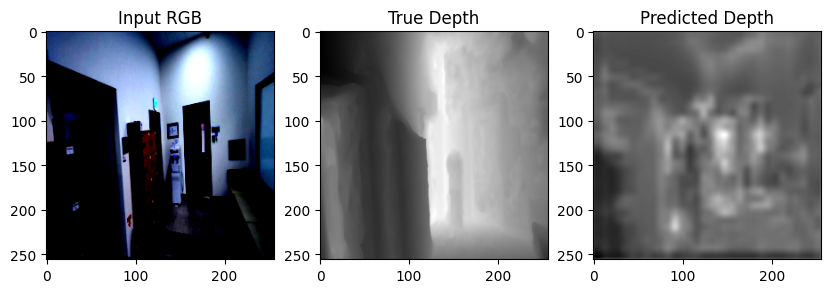

In [41]:
# Example of using the model for prediction

model.eval()  # Set model to evaluate mode
inputs, labels = next(iter(dataloader))
inputs = inputs.to(device)  # Move inputs to device (GPU or CPU)
with torch.no_grad():
    outputs = model(inputs)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(inputs[0].cpu().permute(1, 2, 0))
    plt.title('Input RGB')
    plt.subplot(1, 3, 2)
    plt.imshow(labels[0][0], cmap='gray')
    plt.title('True Depth')
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[0][0].cpu(), cmap='gray')
    plt.title('Predicted Depth')
    plt.show()

In [42]:
import plotly.graph_objs as go
from torch.utils.data import DataLoader
import torch
import plotly.subplots as sp

# Assuming 'model' and 'dataloader' are defined elsewhere in your code

model.eval()  # Set model to evaluate mode
inputs, labels = next(iter(dataloader))
inputs = inputs.to(device)  # Move inputs to device (GPU or CPU)

with torch.no_grad():
    outputs = model(inputs)

    # Convert tensors to numpy for plotting with Plotly
    input_image = inputs[0].permute(1, 2, 0).cpu().detach().numpy()
    true_depth = labels[0][0].cpu().detach().numpy()
    predicted_depth = outputs[0][0].cpu().detach().numpy()

    # Create a figure with subplots
    # fig = go.Figure()
    fig = sp.make_subplots(rows=1, cols=3)

    # Input RGB image
    fig.add_trace(
        go.Heatmap(z=input_image[::-1,:,0], colorscale='Gray', showscale=False),
        row=1, col=1
    )

    # True depth map
    fig.add_trace(
        go.Heatmap(z=true_depth[::-1,:], colorscale='Gray', showscale=False),
        row=1, col=2
    )

    # Predicted depth map
    fig.add_trace(
        go.Heatmap(z=predicted_depth[::-1,:], colorscale='Gray', showscale=False),
        row=1, col=3
    )

    # Update layout to adjust visual aspects
    fig.update_layout(
        title_text='Input RGB and Depth Maps',
        width=900,
        height=300,
        template="plotly_white"
    )

    fig.show()

# Torch Hub Model Test

In [43]:
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning:

You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour

Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiD

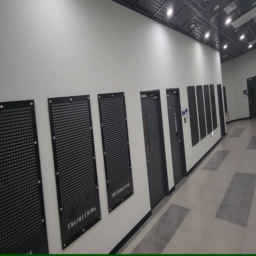

In [44]:
path = '/content/drive/MyDrive/resized_images'

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        depth_image = Image.open(depth_path)
        rgb_image = Image.open(rgb_path)

        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image, depth_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = DepthDataset(path)
img = dataset[0][0]
img

In [47]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)  # Convert to NumPy array first
    img = transform(img).to(device)
    return img

transform = midas_transforms.small_transform
# Convert the image to a NumPy array before applying the transform
input_batch = transform(np.array(img)).to(device)

In [50]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        # Use input_batch.shape instead of img.shape
        size=input_batch.shape[2:],  # Interpolate to the original image dimensions
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()
plt.imshow(output)

In [53]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# MiDAS 모델 불러오기
model_type = "DPT_Large"  # 또는 "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()
'''
# MiDAS 변환기 불러오기
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type in ["DPT_Large", "DPT_Hybrid"]:
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform
'''
# 사용자 정의 transform 함수 -> type
def custom_transform(image):
    # 이미지 크기 조정
    image = cv2.resize(image, (384, 384))  # 원하는 크기로 조정
    image = image / 255.0  # 정규화
    return torch.tensor(image).permute(2, 0, 1).float()  # HWC에서 CHW로 변환

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)  # 이미지를 NumPy 배열로 변환
    img = custom_transform(img)  # 사용자 정의 변환 적용
    img = img.to(device)  # GPU로 이동
    return img

# Depth Estimation 함수
def estimate_depth(image_path):
    img = preprocess_image(image_path)
    with torch.no_grad():
        prediction = midas(img.unsqueeze(0))
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[1:],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    output = prediction.cpu().numpy()
    return output

# 예제 이미지에 대해 Depth Estimation 수행
image_paths = [
    "/content/drive/MyDrive/resized_images/rgb_frame000135.png",
    "/content/drive/MyDrive/resized_images/rgb_frame000520.png",
    "/content/drive/MyDrive/resized_images/rgb_frame000990.png"
]
disparity_maps = [estimate_depth(image_path) for image_path in image_paths]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


**Ground Truth Depth Map 불러오기**

In [60]:
# Ground Truth Depth Map 불러오기
ground_truth_depth_maps = [
    cv2.imread("/content/drive/MyDrive/resized_images/depth_20240501_184023.mp4_frame000135.png.depth.exr.tiff", cv2.IMREAD_GRAYSCALE),
    cv2.imread("/content/drive/MyDrive/resized_images/depth_20240501_184023.mp4_frame000520.png.depth.exr.tiff", cv2.IMREAD_GRAYSCALE),
    cv2.imread("/content/drive/MyDrive/resized_images/depth_20240501_184023.mp4_frame000990.png.depth.exr.tiff", cv2.IMREAD_GRAYSCALE)
]

# Check if the images loaded correctly
for i, gt_depth in enumerate(ground_truth_depth_maps):
    if gt_depth is None:
        print(f"Failed to load ground truth depth map {i+1}")
    else:
        print(f"Ground truth depth map {i+1} loaded successfully with shape: {gt_depth.shape}")




Failed to load ground truth depth map 1
Failed to load ground truth depth map 2
Failed to load ground truth depth map 3


**Scale과 Bias 추정**
-  Linear Regression을 사용하여 Disparity Map을 Metric Depth Map으로 변환하는 Scale과 Bias 구하기

In [55]:
from sklearn.linear_model import LinearRegression

# Disparity Map과 Ground Truth Depth Map을 flatten하여 1D 배열로 변환
def flatten_maps(disparity_map, gt_depth_map):
    mask = gt_depth_map > 0  # Ground Truth가 존재하는 영역만 사용
    disparity_flat = disparity_map[mask].flatten()
    gt_depth_flat = gt_depth_map[mask].flatten()
    return disparity_flat, gt_depth_flat

# Scale과 Bias 추정을 위한 Linear Regression 모델
def estimate_scale_and_bias(disparity_map, gt_depth_map):
    disparity_flat, gt_depth_flat = flatten_maps(disparity_map, gt_depth_map)
    disparity_flat = disparity_flat.reshape(-1, 1)
    gt_depth_flat = gt_depth_flat.reshape(-1, 1)

    reg = LinearRegression().fit(disparity_flat, gt_depth_flat)
    scale = reg.coef_[0][0]
    bias = reg.intercept_[0]
    return scale, bias

# 각 이미지에 대해 Scale과 Bias 추정
scales_biases = [estimate_scale_and_bias(disparity_map, gt_depth) for disparity_map, gt_depth in zip(disparity_maps, ground_truth_depth_maps)]
scales, biases = zip(*scales_biases)


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [51]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# MiDAS 모델 불러오기
model_type = "MiDaS_small"  # MiDaS v2.1 - Small
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# MiDAS 변환기 불러오기
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

# 이미지 전처리 함수
'''
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = ToTensor()(img)  # Convert to tensor
    img = np.array(img.permute(1, 2, 0)) # Convert to NumPy array and rearrange dimensions
    img = transform(img).to(device)
    return img
'''
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)  # Convert to NumPy array first
    img = transform(img).to(device)
    return img


# Depth Estimation 함수
def estimate_depth(image_path):
    img = preprocess_image(image_path)
    with torch.no_grad():
        prediction = midas(img.unsqueeze(0))
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[1:],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    output = prediction.cpu().numpy()
    return output

# 예제 이미지에 대해 Depth Estimation 수행
image_paths = [
    "/content/drive/MyDrive/resized_images/rgb_frame000135.png",
    "/content/drive/MyDrive/resized_images/rgb_frame000520.png",
    "/content/drive/MyDrive/resized_images/rgb_frame000990.png"
]
depth_maps = [estimate_depth(image_path) for image_path in image_paths]

# Ground Truth Depth Map 불러오기
ground_truth_depth_maps = [
    cv2.imread("/content/drive/MyDrive/ground_truth_depth/frame000135_depth.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("/content/drive/MyDrive/ground_truth_depth/frame000520_depth.png", cv2.IMREAD_GRAYSCALE),
    cv2.imread("/content/drive/MyDrive/ground_truth_depth/frame000990_depth.png", cv2.IMREAD_GRAYSCALE)
]

# Disparity Map과 Ground Truth Depth Map을 flatten하여 1D 배열로 변환
def flatten_maps(disparity_map, gt_depth_map):
    mask = gt_depth_map > 0  # Ground Truth가 존재하는 영역만 사용
    disparity_flat = disparity_map[mask].flatten()
    gt_depth_flat = gt_depth_map[mask].flatten()
    return disparity_flat, gt_depth_flat

# Scale과 Bias 추정을 위한 Linear Regression 모델
def estimate_scale_and_bias(disparity_map, gt_depth_map):
    disparity_flat, gt_depth_flat = flatten_maps(disparity_map, gt_depth_map)
    disparity_flat = disparity_flat.reshape(-1, 1)
    gt_depth_flat = gt_depth_flat.reshape(-1, 1)

    reg = LinearRegression().fit(disparity_flat, gt_depth_flat)
    scale = reg.coef_[0][0]
    bias = reg.intercept_[0]
    return scale, bias

# 각 이미지에 대해 Scale과 Bias 추정
scales_biases = [estimate_scale_and_bias(depth_map, gt_depth) for depth_map, gt_depth in zip(depth_maps, ground_truth_depth_maps)]
scales, biases = zip(*scales_biases)

# Metric Depth Map으로 변환
def apply_scale_and_bias(disparity_map, scale, bias):
    return scale * disparity_map + bias

metric_depth_maps = [apply_scale_and_bias(depth_map, scales[i], biases[i]) for i, depth_map in enumerate(depth_maps)]

# Scatter Plot 그리기 함수
def plot_scatter(gt_depth, pred_depth, image_index):
    plt.figure(figsize=(10, 10))
    plt.scatter(gt_depth, pred_depth, alpha=0.5, s=1)
    plt.xlabel('Ground Truth Depth')
    plt.ylabel('Predicted Depth')
    plt.title(f'Scatter Plot for Image {image_index}')
    plt.grid(True)
    plt.show()

# Scatter Plot 그리기
for i, (gt_depth, pred_depth) in enumerate(zip(ground_truth_depth_maps, metric_depth_maps)):
    gt_depth = gt_depth.flatten()
    pred_depth = pred_depth.flatten()
    plot_scatter(gt_depth, pred_depth, i+1)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 257, 257]

**Least Squares Method를 사용한 Scale 및 Bias 추정**

In [ ]:
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 이미지 경로 설정
image_paths = ["frame_135.png", "frame_520.png", "frame_990.png"]
gt_depth_paths = ["gt_depth_135.png", "gt_depth_520.png", "gt_depth_990.png"]

# MiDAS 모델을 사용하여 Depth Estimation 수행
depth_maps = [estimate_depth(image_path) for image_path in image_paths]

# Ground Truth Depth Map 불러오기
ground_truth_depth_maps = [cv2.imread(gt_depth_path, cv2.IMREAD_GRAYSCALE) for gt_depth_path in gt_depth_paths]

# Disparity Map과 Ground Truth Depth Map을 flatten하여 1D 배열로 변환
def flatten_maps(disparity_map, gt_depth_map):
    mask = gt_depth_map > 0  # Ground Truth가 존재하는 영역만 사용
    disparity_flat = disparity_map[mask].flatten()
    gt_depth_flat = gt_depth_map[mask].flatten()
    return disparity_flat, gt_depth_flat

# Scale과 Bias 추정을 위한 Linear Regression 모델
def estimate_scale_and_bias(disparity_map, gt_depth_map):
    disparity_flat, gt_depth_flat = flatten_maps(disparity_map, gt_depth_map)
    disparity_flat = disparity_flat.reshape(-1, 1)
    gt_depth_flat = gt_depth_flat.reshape(-1, 1)

    reg = LinearRegression().fit(disparity_flat, gt_depth_flat)
    scale = reg.coef_[0][0]
    bias = reg.intercept_[0]
    return scale, bias

# 각 이미지에 대해 Scale과 Bias 추정
scales_biases = [estimate_scale_and_bias(depth_map, gt_depth) for depth_map, gt_depth in zip(depth_maps, ground_truth_depth_maps)]
scales, biases = zip(*scales_biases)

# Metric Depth Map으로 변환
def apply_scale_and_bias(disparity_map, scale, bias):
    return scale * disparity_map + bias

metric_depth_maps = [apply_scale_and_bias(depth_map, scales[i], biases[i]) for i, depth_map in enumerate(depth_maps)]

# Scatter Plot 그리기 함수
def plot_scatter(gt_depth, pred_depth, image_index):
    plt.figure(figsize=(10, 10))
    plt.scatter(gt_depth, pred_depth, alpha=0.5, s=1)
    plt.xlabel('Ground Truth Depth')
    plt.ylabel('Predicted Depth')
    plt.title(f'Scatter Plot for Image {image_index}')
    plt.grid(True)
    plt.show()

# Scatter Plot 그리기
for i, (gt_depth, pred_depth) in enumerate(zip(ground_truth_depth_maps, metric_depth_maps)):
    gt_depth = gt_depth.flatten()
    pred_depth = pred_depth.flatten()
    plot_scatter(gt_depth, pred_depth, i+1)
